In [1]:
import mne
import pandas as pd
from patternly.detection import StreamingDetection, AnomalyDetection, ContinuousStreamingDetection
from datetime import datetime, timedelta
from timesmash import Quantizer

data = mne.io.read_raw_edf(f"./data/sc4002e0.rec.edf")
info = data.info
original = data.to_data_frame()

Extracting EDF parameters from /home/drewvlaz/Documents/ZeD/repos/patternly/examples/data/sc4002e0.rec.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [2]:
hz = info['sfreq'] # sampling frequency
WINDOW_SIZE = 20 * hz
WINDOW_OVERLAP = 15 * hz
N_CLUSTERS = 5
QUANTIZE_TYPE = 'simple'
EPS = 0.08
VERBOSE = True
CHANNEL = 'EEG Fpz-Cz'

In [3]:
model = ContinuousStreamingDetection(
    n_clusters=N_CLUSTERS,
    window_size=WINDOW_SIZE,
    window_overlap=WINDOW_OVERLAP,
    quantize_type=QUANTIZE_TYPE,
    eps=EPS,
    verbose=VERBOSE,
    reduce_clusters=False
)
model = model.fit_stream(original[CHANNEL].iloc[:])
predicitons = model.predict()

Quantizing...


In [4]:
import subprocess
import numpy as np
from zedsuite.zutil import Prun, Lsmash
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

# reduce clusters by combining similar ones
representative_seqs = []
for pfsa in model.cluster_PFSA_files:
    representative_seqs.append(Prun(pfsafile=pfsa, data_len=model.window_size, num_repeats=10000).run()[0])

pd.DataFrame(
    Lsmash(data=pd.DataFrame(representative_seqs), data_type='symbolic', sae=False).run(),
    dtype=np.float32
).to_csv(f"for_embedding", sep=' ', header=False, index=False)

subprocess.run(["./bin/embed", "-f", f"for_embedding", "-E", f"embedding"], capture_output=True)
pca = PCA(n_components=2)
embedded_pca = pca.fit_transform(pd.read_csv(f"embedding", sep=' ', header=None, dtype=np.float32).dropna(how='any', axis=1).T)
X = embedded_pca.T[0]
y = embedded_pca.T[1]

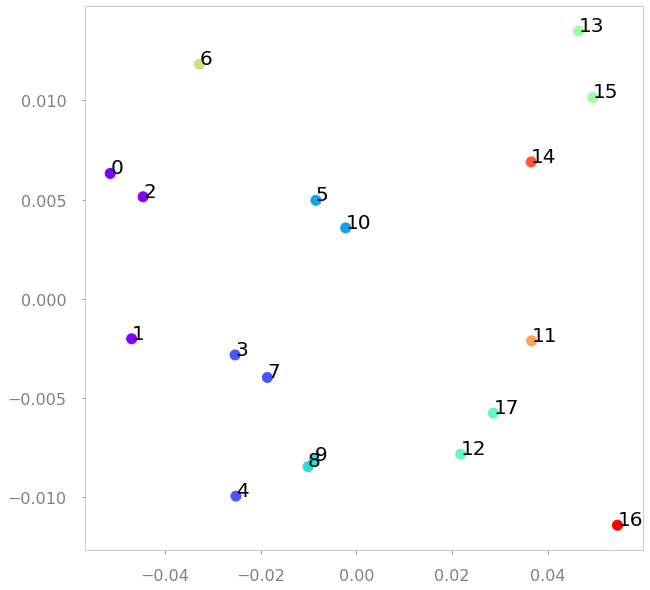

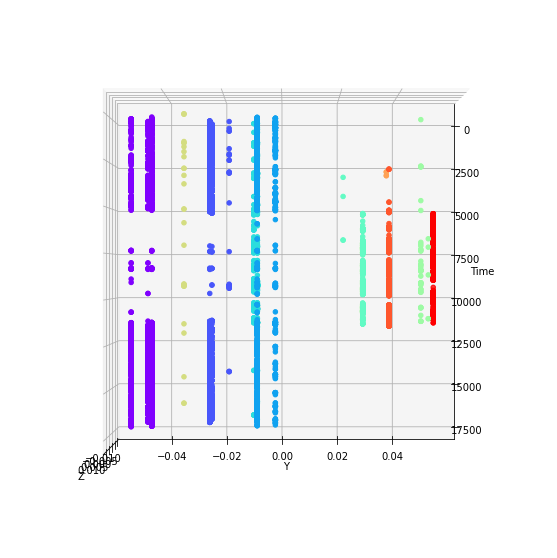

In [5]:
# %matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams["figure.figsize"] = (10, 10)

clustering = DBSCAN(eps=0.008, min_samples=2).fit(embedded_pca)
new_labels = []
labels_iter = max(clustering.labels_) + 1
for l in clustering.labels_:
    if l < 0:
        new_labels.append(labels_iter)
        labels_iter += 1
    else:
        new_labels.append(l)

new_label_map = dict(zip(range(model.n_clusters), new_labels))

cluster_counts = [0 for j in range(model.n_clusters)]
for cluster in model.closest_match:
    cluster_counts[new_label_map[cluster]] += 1
cluster_rank = np.flip(np.argsort(cluster_counts))
base_colors = cm.rainbow(np.linspace(0, 1, np.count_nonzero(cluster_counts)))
colors = [base_colors[new_label_map[c]] for c in range(model.n_clusters)]
plt.scatter(X, y, s=100, color=colors)#, alpha=alphas)

annotations=[str(i) for i in range(model.n_clusters)]
for j, label in enumerate(annotations):
    plt.annotate(label, (X[j], y[j]), fontsize=20)

ax=plt.gca()
plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
plt.setp(ax.get_yticklabels(), fontsize=16)
ax.tick_params(axis='x', colors='.5')    
ax.tick_params(axis='y', colors='.5',pad=15)  
ax.yaxis.offsetText.set_fontsize(16)
ax.spines['bottom'].set_color('.75')
ax.spines['top'].set_color('.75') 
ax.spines['right'].set_color('.75')
ax.spines['left'].set_color('.75')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

colors = cm.rainbow(np.linspace(0, 1, np.count_nonzero(cluster_counts)))
for cluster in sorted(model.predicted_active_pfsas.keys()):
    color = colors[new_label_map[cluster]]
    times = model.predicted_active_pfsas[cluster]
    ax.scatter(times, np.full(len(times), X[cluster]), np.full(len(times), y[cluster]), color=color)
    pass

ax.set_xlabel('Time')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(90, 0)
plt.show()